# Spiral ODE

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/spiral/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/spiral/).*

## Setup

Load necessary packages

In [1]:
using ApproximateGPs
using Plots
using LinearAlgebra
using DifferentialEquations
using InducingPoints
using GPDiffEq
using Optimization, OptimizationOptimJL

First we define an ODE and generate some data points from it.

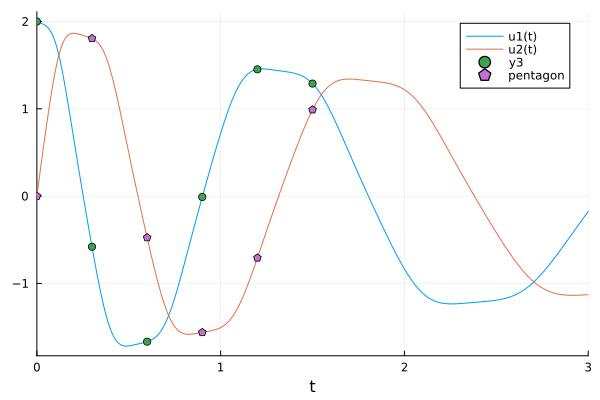

In [2]:
u0 = [2.0; 0.0]
datasize = 6
tspan = (0.0, 3.0)
datatspan = (0.0, 1.5)
datatsteps = range(datatspan[1], datatspan[2]; length=datasize)

function trueODEfunc(u, p, t)
    du = similar(u)
    true_A = [-0.1 2.0; -2.0 -0.1]
    return du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
sol = solve(prob_trueode, Tsit5())
ode_data = Array(sol(datatsteps))

traj = sol(datatsteps);

p = plot(sol)
scatter!(p, datatsteps, ode_data[1, :]; markersize=4)#, markerstyle = :star)
scatter!(p, datatsteps, ode_data[2, :]; m=(4, :pentagon), lab="pentagon")#, markerstyle = :star)

## Gradient data
For this example we get gradient observations from our trajectory data via finite differences

First, we set all necessary variables

In [3]:
scaker = with_lengthscale(SqExponentialKernel(), 1.0)
moker = IndependentMOKernel(scaker)
##ToDo: make ODE data into col_vecs and add number programmatically
x = MOInput(datatsteps, 2)
σ_n = 1e-6
y = ode_data'[:]
nothing #hide

and build a finite GP from them

In [4]:
g = GP(moker)
gt = g(x, σ_n)
gt_post = posterior(gt, y)
nothing #hide

Now we use the following convenience functions to a loglikelihood loss function and a function to rebuild the gp with the optimal parameters.
Note that we use optimize over the logarithm of the parameters, to ensure their positivity. For more details see [this KernelFunctions.jl example](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/train-kernel-parameters/)

In [5]:
loss, buildgppost = gp_negloglikelihood(gt, x, y)

p0 = log.([1.0])
unfl(x) = exp.(x)

#optp = gp_train(loss ∘ unfl, p0; show_trace=true, show_every=15)

unfl (generic function with 1 method)

Optimizing:

In [6]:
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> (loss ∘ unfl)(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

optp = Optimization.solve(optprob, NelderMead(); maxiters=300)

optparams = unfl(optp)

1-element Vector{Float64}:
 4.811724785121101

Now we can build a FiniteGP with the optimized parameters,

In [7]:
optpost = buildgppost(optparams)
nothing #hide

which fits pretty well

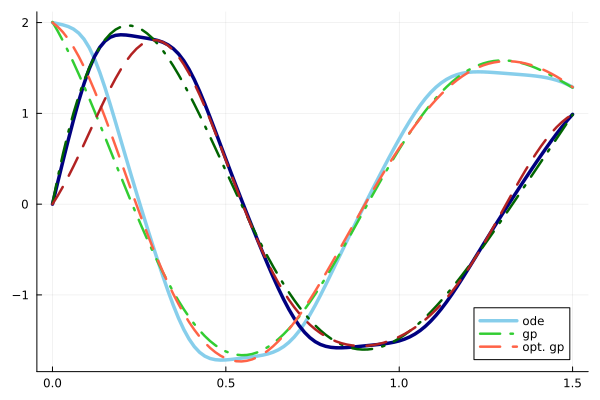

In [8]:
t_plot = range(datatspan...; length=100)
t_plot_mo = MOInput(t_plot, 2)
opt_pred_mean = mean(optpost, t_plot_mo)
opt_pred_mean = reshape(opt_pred_mean, :, 2)
pred_mean = mean(gt_post, t_plot_mo)
pred_mean = reshape(pred_mean, :, 2)
# pred_cov = diag(cov(optpost, t_plot_mo))
# pred_cov = reshape(pred_cov, :, 2)
# plot!(t_plot, pred_mean; ribbons = pred_cov)
plot(sol(t_plot); label=["ode" ""], color=[:skyblue :navy], linewidth=3.5)
plot!(
    t_plot,
    pred_mean;
    label=["gp" ""],
    color=[:limegreen :darkgreen],
    linewidth=2.5,
    linestyle=:dashdot,
)
plot!(
    t_plot,
    opt_pred_mean;
    label=["opt. gp" ""],
    color=[:tomato :firebrick],
    linewidth=2.5,
    linestyle=:dash,
)

GPs are closed under linear operators, which means that we can very easily obtain derivative information:

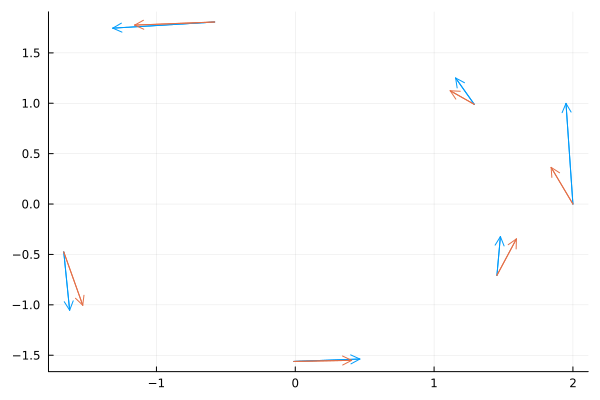

In [9]:
deriv_post = differentiate(optpost)
du_pred_mean = mean(deriv_post, x)
du_pred_mean = reshape(du_pred_mean, :, 2)

du = trueODEfunc.(eachcol(ode_data), 0, 0)
sf = maximum(norm.(du))
quiver(
    ode_data[1, :],
    ode_data[2, :];
    quiver=(getindex.(du, 1) / sf, getindex.(du, 2) / sf),
    label="true",
)
quiver!(
    ode_data[1, :],
    ode_data[2, :];
    quiver=(du_pred_mean[:, 1] / sf, du_pred_mean[:, 2] / sf),
    label="predicted data",
)

This leaves us with `u` and `udot` pairs as in the input and output:

In [10]:
u = ColVecs(ode_data)
udot = ColVecs(du_pred_mean')

6-element KernelFunctions.ColVecs{Float64, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, SubArray{Float64, 1, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false}}:
 [-2.514577473406387, 5.829135218571004]
 [-9.236997438370901, -0.49233983545818427]
 [2.1915978362378845, -8.46964320949868]
 [6.665646632944082, 0.17194761064207487]
 [2.24816840509318, 5.797948829910114]
 [-2.7762770724157497, 2.161944469033859]

## Building a model
Now we build a model for the the ODE.

In [11]:
scaker = with_lengthscale(SqExponentialKernel(), ones(2))
moker = IndependentMOKernel(scaker)

u_mo = MOInput(u, 2)
σ_n = 1e-6
y = reduce(vcat, udot.X')
nothing #hide

and build a posterior GP

In [12]:
gpfun = GP(moker)
fin_gpfun = gpfun(u_mo, σ_n)
post_gpfun = posterior(fin_gpfun, y)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByOutputs{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, KernelFunctions.ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Int64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}(AbstractGPs.ZeroMean{Float64}(), Independent Multi-Output Kernel
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))

and optimize

In [13]:
loss, buildgppost = gp_negloglikelihood(fin_gpfun, u_mo, y)

p0 = log.(ones(2))
unfl(x) = exp.(x)

optf = Optimization.OptimizationFunction((x, p) -> (loss ∘ unfl)(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

optp = Optimization.solve(optprob, NelderMead(); maxiters=300)

optparams = unfl(optp)

2-element Vector{Float64}:
 0.8649528955284745
 1.1565394805916194

We build a posterior GP with the optimized parameters,

In [14]:
optpost = buildgppost(optparams)
nothing #hide

and a GP ODE function

In [15]:
gpff = GPODEFunction(optpost)

(::GPDiffEq.PullSoversModule.GPODEFunction{false, AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByOutputs{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, KernelFunctions.ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Int64}, Vector{Float64}}}}, AbstractGPs.PosteriorGP{GPDiffEq.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, AbstractGPs.ZeroMean{Float64},

Plotting the vector field

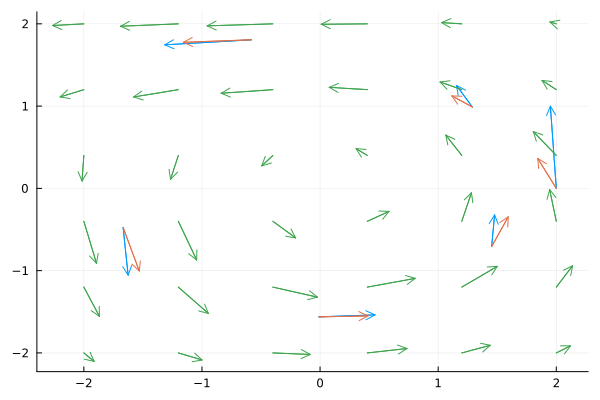

In [16]:
ug = range(-2.0, 2.0; length=6)
ug = vcat.(ug, ug')[:]
gp_pred_mean = gpff.(ug)
quiver!(
    getindex.(ug, 1),
    getindex.(ug, 2);
    quiver=(getindex.(gp_pred_mean, 1) / sf, getindex.(gp_pred_mean, 2) / sf),
    label="GP model",
    legend=:bottomright,
)

and incorporate into a GP ode model. Unfortunately, this does not currently fully match the previous implementation.

In [17]:
gpprob = GPODEProblem(gpff, u0, tspan)

gpsol = solve(gpprob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 26-element Vector{Float64}:
 0.0
 0.00017146639452012114
 0.0018861303397213324
 0.013402844734457476
 0.040099200542306514
 0.08143335628537204
 0.14043107711968494
 0.2252504034339457
 0.3374672089638173
 0.45243490594964253
 ⋮
 1.6164641580562638
 1.8124158201918246
 2.003669691707407
 2.157656920598998
 2.312660477170824
 2.523329784749307
 2.7201424972561874
 2.9038787541041766
 3.0
u: 26-element Vector{Vector{Float64}}:
 [2.0, 0.0]
 [1.9995686377818713, 0.0009993567490425262]
 [1.995233513886102, 0.010976938819698539]
 [1.9651835611100839, 0.07717355655395974]
 [1.8908457874461093, 0.2239879538026428]
 [1.770227347583797, 0.4286854834008802]
 [1.6011167854875141, 0.6691448355461217]
 [1.3698284930180573, 0.9225193922002746]
 [1.0433953915867518, 1.139077742739306]
 [0.5971116850386535, 1.2608472340509163]
 ⋮
 [0.44866007770032856, -1.8281640435

#### Phase plot

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


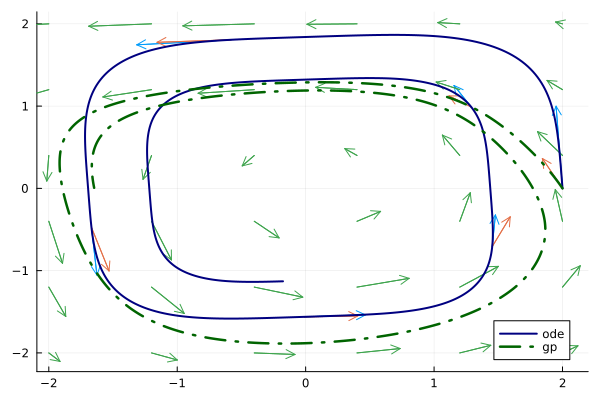

In [18]:
plot!(sol; vars=(1, 2), label="ode", linewidth=2, color=:navy)
plot!(gpsol; vars=(1, 2), label="gp", linewidth=2.5, linestyle=:dashdot, color=:darkgreen)

#### Time Series Plots

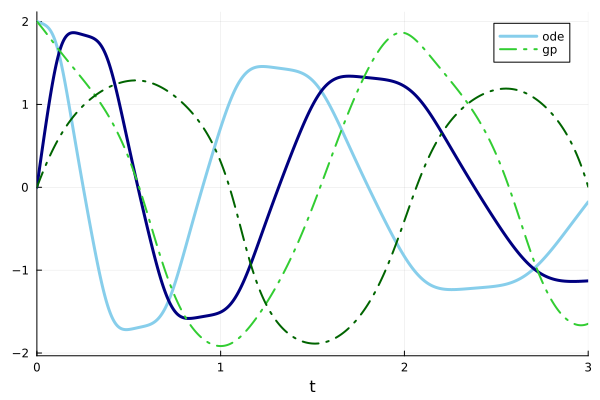

In [19]:
plot(sol; label=["ode" ""], color=[:skyblue :navy], linewidth=3)
plot!(
    gpsol; label=["gp" ""], color=[:limegreen :darkgreen], linewidth=2, linestyle=:dashdot
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*